# Understanding Architecture

- Main ideas:
    1. Coding input and output of each kind of layer;

## Initial Setup

In [30]:
# Reload modules automatically before executing code.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Add SITS-BERT source code for import.
import sys

path = "/geosatlearn_app/ml_models/sits-bert"
if path not in sys.path:
    sys.path.append(path)
    print(f">>> Added {path} to sys.path")

In [32]:
# Initial imports.
import math
import torch

import numpy as np
import pandas as pd

import seaborn as sns

import torch.nn.functional as F

import matplotlib.pyplot as plt

from sitsbert.model.transformer import TransformerBlock
from sitsbert.model.attention import Attention, MultiHeadedAttention
from sitsbert.model.embedding import BERTEmbedding
from sitsbert.model.embedding.position import PositionalEncoding

## General Hyperparameters

In [33]:
h = 8  # Number of attention heads.
d_model = 256  # Dimensionality of the model (hidden size).
dropout = 0.1  # Dropout rate applied to attention probabilities (defaul
num_features = 10  # Number of satellite bands.
dropout = 0.1  # Dropout rate applied to the input embeddings.
d_ff = int(4 * d_model)  # Dimensionality of the feed-forward network.

## Positional Encoders

In [34]:
# Create positional encoding for a model with dimension 256.
pos_encoder = PositionalEncoding(d_model=d_model)

# Get positional encodings for days 1, 10, and 100
days = torch.tensor([1, 10, 100])
encodings = pos_encoder(days)
print(f">>> Positional encodings:\nDays: {days.numpy()}\nPE shape: {encodings.shape}")

>>> Positional encodings:
Days: [  1  10 100]
PE shape: torch.Size([3, 256])


In [35]:
# Visualize PEs in a plot.
all_days_in_a_year = torch.arange(1, 366)  # Days in a year (1 to 365).
pes = pos_encoder(all_days_in_a_year)

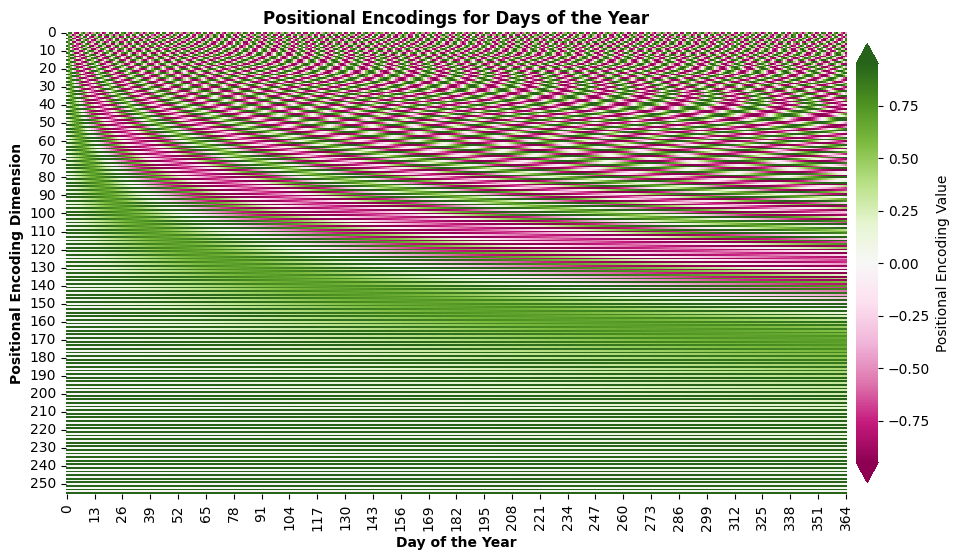

In [36]:
# Heatmap visualization of positional encodings.
ax = sns.heatmap(
    data=pes.T,
    vmin=-0.95,
    vmax=0.95,
    annot=False,
    cmap="PiYG",
    cbar=True,
    cbar_kws={
        "label": "Positional Encoding Value",
        "extend": "both",
        "shrink": 0.95,
        "orientation": "vertical",
        "pad": 0.01,
    },
)
ax.figure.set_size_inches(12, 6)
ax.set_xlabel("Day of the Year", weight="bold")
ax.set_ylabel("Positional Encoding Dimension", weight="bold")
ax.set_title("Positional Encodings for Days of the Year", weight="bold");

In [37]:
# Create timestamps for a agricultural year beginning on September 1st and ending on August 31st of the next year.
timestamps = pd.date_range(start="2024-09-01", end="2025-08-31", freq="D")

# Convert timestamps to day of the year.
days_of_year = timestamps.dayofyear

# Create positional encodings for these days.
pes_agricultural_year = pos_encoder(torch.tensor(days_of_year))

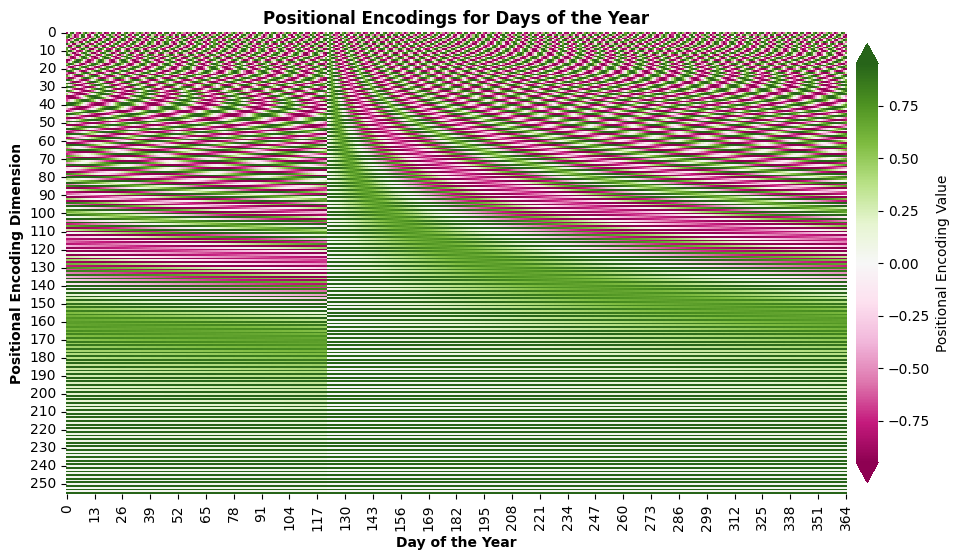

In [38]:
# Heatmap visualization of positional encodings.
ax = sns.heatmap(
    data=pes_agricultural_year.T,
    vmin=-0.95,
    vmax=0.95,
    annot=False,
    cmap="PiYG",
    cbar=True,
    cbar_kws={
        "label": "Positional Encoding Value",
        "extend": "both",
        "shrink": 0.95,
        "orientation": "vertical",
        "pad": 0.01,
    },
)
ax.figure.set_size_inches(12, 6)
ax.set_xlabel("Day of the Year", weight="bold")
ax.set_ylabel("Positional Encoding Dimension", weight="bold")
ax.set_title("Positional Encodings for Days of the Year", weight="bold");

## Embedding Layer

In [39]:
# Create a BERT embedding layer
bert_embed = BERTEmbedding(
    num_features=num_features, embedding_dim=int(d_model / 2), dropout=dropout
)

# Sample input sequence (batch_size=2, seq_length=5, features=10)
input_seq = torch.randn(2, 5, 10)

# Sample day-of-year sequence (batch_size=2, seq_length=5)
doy_seq = torch.tensor([[32, 64, 96, 128, 160], [50, 100, 150, 200, 250]])

# Get embeddings
embeddings = bert_embed(input_sequence=input_seq, doy_sequence=doy_seq)
print(f">>> Embeddings shape: {embeddings.shape}")

>>> Embeddings shape: torch.Size([2, 5, 256])


## Attention

In [40]:
# Instance of the attention class.
attention = Attention()

# Batch of 32, sequence length 64, hidden size 256.
query = torch.randn(32, 64, 256)
key = torch.randn(32, 64, 256)
value = torch.randn(32, 64, 256)

# Mask indicating valid positions.
mask = torch.ones(32, 1, 64)

# Do it.
output, attn_probs = attention(query, key, value, mask)

# Print the shapes of the output and attention probabilities.
print(
    f">>> Output shape: {output.shape},\n>>> Attention probabilities shape: {attn_probs.shape}"
)

>>> Output shape: torch.Size([32, 64, 256]),
>>> Attention probabilities shape: torch.Size([32, 64, 64])


## Multi-Headed Attention

In [41]:
# Create a MultiHeadedAttention instance.
mha = MultiHeadedAttention(h=h, d_model=d_model, dropout=dropout)

# Batch of 32, sequence length 64, hidden size 256.
query = torch.randn(32, 64, 256)
key = torch.randn(32, 64, 256)
value = torch.randn(32, 64, 256)

# Mask indicating valid positions (TODO: is not working!)
mask = torch.ones(32, 1, 64)

# Print the shapes of the output tensors.
output = mha(query, key, value, mask=None)
print(output.shape)

torch.Size([32, 64, 256])


## Transformer Block

In [42]:
# Create a TransformerBlock instance.
transformer = TransformerBlock(
    hidden=d_model, attn_heads=h, feed_forward_hidden=d_ff, dropout=dropout
)

# Process a batch of sequences.
batch_size = 32
seq_length = 64
x = torch.randn(batch_size, seq_length, d_model)

# No masking.
mask = torch.ones(batch_size, seq_length)

# Do it.
output = transformer(x=x, mask=None)

# Count number of parameters in the transformer block.
n_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)

# Print the shape of the output tensor.
print(f">>> Number of parameters in TransformerBlock: {n_params}")
print(f">>> Input shape: {x.shape}")
print(f">>> Output shape: {output.shape}")

>>> Number of parameters in TransformerBlock: 789760
>>> Input shape: torch.Size([32, 64, 256])
>>> Output shape: torch.Size([32, 64, 256])
